<a href="https://colab.research.google.com/github/saharzamanian/BLEPseudo-RandomIDs/blob/main/Ephemeral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from numpy import unique, argmax
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, Conv1D, MaxPool1D
import tensorflow.keras as K
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot
import matplotlib.pyplot as plt

import hashlib
import time

import random

In [ ]:
def generate_ephemeral_id(seed):
    data = f"{seed}{time.time()}".encode('utf-8')
    hash_object = hashlib.sha256(data)
    ephemeral_id = hash_object.hexdigest()
    return ephemeral_id


def string_to_uint32_array(id):
    return [int(id[i:i+8], 16) for i in range(0, len(id), 8)]

In [ ]:
def generate_data(size: int, seeds):
  data = np.empty([size, 8], dtype=np.uint32)
  labels = np.empty([size, 1], dtype=np.ubyte)

  for data_index in range(size):
    device_number = random.randint(0, len(seeds)-1)
    labels[data_index] = device_number
    ephemeral_id = generate_ephemeral_id(seeds[device_number])
    data[data_index] = string_to_uint32_array(ephemeral_id)

  return (data, labels)

In [ ]:
SEEDS = ["Device0", "Device1", "Device2", "Device3", "Device4", "Device5", "Device6", "Device7"]

NUM_TRAIN_DATA = 2000
NUM_VAL_DATA = 300
NUM_TEST_DATA = 100

training_data, training_labels = generate_data(NUM_TRAIN_DATA, SEEDS)
validation_data, validation_labels = generate_data(NUM_VAL_DATA, SEEDS)
test_data, test_labels = generate_data(NUM_TEST_DATA, SEEDS)

In [ ]:
training_data = training_data.reshape((-1, training_data.shape[1], 1))
print("Size of training data is ", np.shape(training_data))
validation_data = validation_data.reshape((-1, validation_data.shape[1], 1))
print("Size of validation data is ", np.shape(validation_data))
test_data = test_data.reshape((-1, test_data.shape[1], 1))
print("Size of validation data is ", np.shape(test_data))

Size of training data is  (2000, 8, 1)
Size of validation data is  (300, 8, 1)
Size of validation data is  (100, 8, 1)


In [ ]:
model = Sequential([
    Conv1D(16, 3, activation='relu', input_shape=training_data.shape[1:]),
    Dropout(0.5),
    MaxPool1D(2),
    Flatten(),
    #Dense(400, activation='relu', input_shape=training_data.shape[1:]),
    Dense(len(SEEDS), activation='softmax')
])

model.summary()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_2 = model.fit(training_data, training_labels, validation_data=(validation_data, validation_labels), batch_size=10, epochs=10)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 6, 16)             64        
                                                                 
 dropout_1 (Dropout)         (None, 6, 16)             0         
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 3, 16)             0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 48)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 392       
                                                                 
Total params: 456 (1.78 KB)
Trainable params: 456 (1.78 KB)
Non-trainable params: 0 (0.00 Byte)
________________________

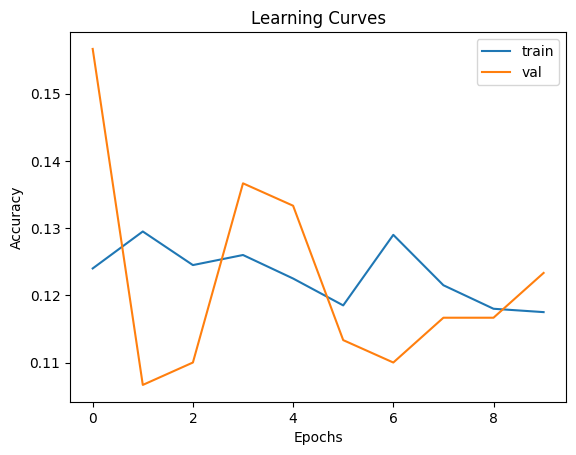

In [ ]:
# ploting the learning curves
pyplot.title('Learning Curves')
pyplot.xlabel('Epochs')
pyplot.ylabel('Accuracy')
pyplot.plot(history_2.history['accuracy'], label='train')
pyplot.plot(history_2.history['val_accuracy'], label='val')
pyplot.legend()
pyplot.show()

In [ ]:
# evaluate the model
loss, accuracy = model.evaluate(test_data, test_labels, verbose=0)
print(f'Accuracy: {accuracy*100}')

Accuracy: 18.000000715255737


In [ ]:
index = 3
yhat = model.predict([np.expand_dims(test_data[index], axis=0)], verbose = 0)
print('Predicted label: {}'.format(argmax(yhat)))
print('Actual label: {}'.format(test_labels[index]))

Predicted label: 3
Actual label: [1]
